# covid-nsw

Driven by SQL, I explore [NSW COVID-19 cases by location](https://data.nsw.gov.au/search/dataset/ds-nsw-ckan-aefcde60-3b0c-4bc0-9af1-6fe652944ec2/details?q=).


## Setup


Create SQL engine and load input CSV into a SQLite table:


In [1]:
from glob import glob
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("sqlite://", echo=False)

covid_df = pd.read_csv(glob("./input/confirmed_cases*.csv")[0])
covid_df.to_sql("covid", engine, if_exists="replace", index=False)
covid_df.head(3)


,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,confirmed_by_pcr,confirmed_cases_count
0,2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A),NaN,1
1,2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C),NaN,1
2,2020-01-25,2134,X700,Sydney,11300,Burwood (A),NaN,1


## Cleaning


### Missing

There are missing values in both `postcode` and `confirmed_by_pcr` columns:


In [2]:
pd.read_sql_query(
    """
    SELECT SUM(CASE WHEN notification_date IS NULL THEN 1 ELSE 0 END) AS 'nd_miss',
        SUM(CASE WHEN postcode IS 'None' THEN 1 ELSE 0 END) AS 'pc_miss',
        SUM(CASE WHEN lhd_2010_code IS  NULL THEN 1 ELSE 0 END) AS 'lhdc_miss',
        SUM(CASE WHEN lhd_2010_name IS NULL THEN 1 ELSE 0 END) AS 'lhdn_miss',
        SUM(CASE WHEN lga_code19 IS NULL THEN 1 ELSE 0 END) AS 'lgac_miss',
        SUM(CASE WHEN lga_name19 IS NULL THEN 1 ELSE 0 END) AS 'lgan_miss',
        SUM(CASE WHEN confirmed_by_pcr IS NULL THEN 1 ELSE 0 END) AS 'pcr_miss',
        SUM(CASE WHEN confirmed_cases_count IS NULL THEN 1 ELSE 0 END) AS 'confirmed_cases_miss'
    FROM covid
""",
    engine,
)


,nd_miss,pc_miss,lhdc_miss,lhdn_miss,lgac_miss,lgan_miss,pcr_miss,confirmed_cases_miss
0,0,530,0,0,0,0,41075,0


Although Local Government Area (LGA) information is not missing for rows with missing `postcode`, `postcode` is nevertheless difficult to impute as there can be multiple postcodes in an LGA (1:M).

Similarly, `confirmed_by_pcr` is difficult to impute. It records whether a case detected by Rapid Antigen Tests (RAT), reported to NSW Health, was also confirmed by PCR. All missing values were prior to 19 Jan 2022 and would be difficult to impute.


In [3]:
pd.read_sql_query(
    """
        SELECT MAX(notification_date) AS 'latest_pcr_miss_date'
        FROM covid
        WHERE confirmed_by_pcr IS NULL
    """,
    engine,
)


,latest_pcr_miss_date
0,2022-01-19


## Analysis

In this section, I use SQL queries and Python visualisations to highlight insights in the data.


### Daily cases have trended upwards
Since reporting started on 25 Jan 2020, daily cases have trended upwards, **peaking in Jan 2022**, and then to a lesser peak in Mar 2022.

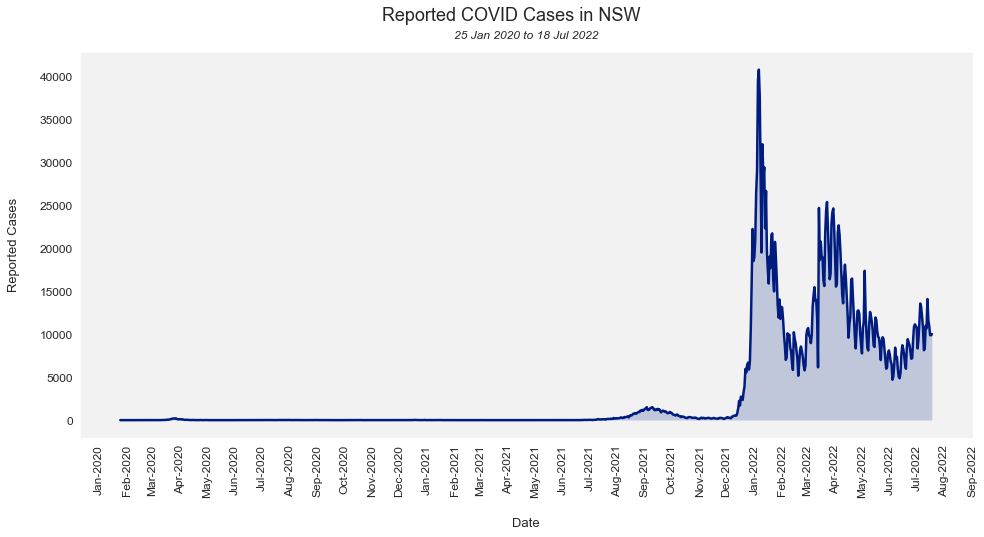

<Figure size 432x288 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

# querying
daily_cases = pd.read_sql_query(
    """
        SELECT DATE(notification_date) AS 'date',
            SUM(confirmed_cases_count) AS 'reported_cases'
        FROM covid
        GROUP BY 1
    """,
    engine,
)

# transforming and extracting from DataFrame for visualisation
daily_cases["date"] = pd.to_datetime(daily_cases["date"], format="%Y-%m-%d")
start_date = daily_cases.date.min().strftime("%d %b %Y")
end_date = daily_cases.date.max().strftime("%d %b %Y")

# plotting visualisation
sns.set_style("dark", {"axes.facecolor": "0.95"})
sns.set_palette("dark")

fig, ax = plt.subplots(figsize=(16, 7))
sns.lineplot(x="date", y="reported_cases", data=daily_cases, ax=ax, linewidth=2.5)
plt.fill_between(x=daily_cases["date"], y1=daily_cases["reported_cases"], alpha=0.2)

# setting x-axis ticks
ax.xaxis.set_major_locator(md.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(md.DateFormatter("%b-%Y"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.tick_params(axis="both", labelsize=12)

# modifying line-chart parameters
ax.figure.suptitle("Reported COVID Cases in NSW", fontsize=18)
ax.set_title(f"{start_date} to {end_date}", y=1.02, style="italic")
ax.set_xlabel("Date", fontsize=13, labelpad=20)
ax.set_ylabel("Reported Cases", fontsize=13, labelpad=20)

fig.subplots_adjust(top=0.89)

plt.show()
plt.clf()


#### Cases peaked in Jan 2022, and then in Mar 2022...
The **top 10 daily cases all occurred in _Jan 2022_**. 11th to 16th are part of the Mar 2022 spike. 

In [5]:
pd.read_sql_query(
    """
    SELECT
        RANK() OVER (
            ORDER BY SUM(confirmed_cases_count) DESC
        ) AS 'rank',
        DATE(notification_date) AS 'date',
        STRFTIME('%m-%Y', notification_date) AS 'month_year',
        SUM(confirmed_cases_count) AS 'reported_cases'
    FROM covid
    GROUP BY 2
    ORDER BY 4 DESC
    LIMIT 20
""",
    engine,
)


,rank,date,month_year,reported_cases
0,1,2022-01-06,01-2022,40752
1,2,2022-01-05,01-2022,39431
2,3,2022-01-07,01-2022,37676
3,4,2022-01-10,01-2022,32070
4,5,2022-01-12,01-2022,29411
5,6,2022-01-04,01-2022,29031
6,7,2022-01-08,01-2022,28174
7,8,2022-01-11,01-2022,28137
8,9,2022-01-14,01-2022,26646
9,10,2022-01-03,01-2022,26374


#### Cases typically peak mid-week, decreasing into the weekend, then rebounding on Mondays... 
Over the reporting period, average daily cases tend to increase after the weekend, **peaking on Wednesdays** (daily average = 14.9 cases), before **reducing into the weekend until Sundays** (daily average = 11 cases).

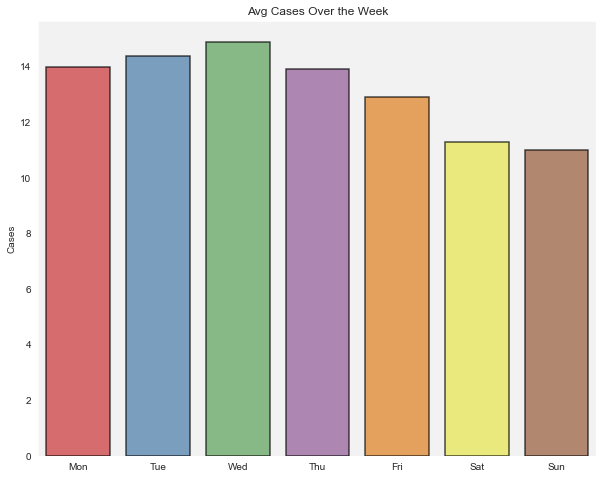

,day_of_wk,cases_avg
1,Mon,14.0
2,Tue,14.4
3,Wed,14.9
4,Thu,13.9
5,Fri,12.9
6,Sat,11.3
0,Sun,11.0


<Figure size 432x288 with 0 Axes>

In [11]:
days_of_wk = pd.read_sql_query(
    """
    SELECT
        SUBSTR(
            'SunMonTueWedThuFriSat',
            1 + 3 * STRFTIME('%w', notification_date), 3
        ) AS 'day_of_wk',
        ROUND(
            AVG(confirmed_cases_count), 1
        ) AS 'cases_avg'
    FROM covid
    GROUP BY 1
    ORDER BY STRFTIME('%w', notification_date)
""",
    engine,
)

# Ordering by STRFTIME('%w') would start the week on Sunday instead of Monday
days_of_wk["day_of_wk"] = pd.Categorical(
    days_of_wk.day_of_wk,
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    ordered=True,
)
days_of_wk.sort_values("day_of_wk", inplace=True)

# Plotting
sns.set_palette("Set1", 7)

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=days_of_wk,
    x="day_of_wk",
    y="cases_avg",
    edgecolor="black",
    linewidth=1.5,
    ax=ax,
    alpha=0.7,
).set(xlabel=None, ylabel="Cases", title="Avg Cases Over the Week")

plt.show()
plt.clf()

display(days_of_wk)


### "Zero" days
Days without any COVID-19 cases were more frequent at the beginning of the reporting period. **Feb 2020 was an entire *month* of zero days.**

In [6]:
zero_days_df = pd.read_sql_query(
    """
        WITH RECURSIVE dates(date) AS (
            VALUES((
                SELECT MIN(notification_date)
                FROM covid
                )
            )
            UNION ALL
            SELECT DATE(date, '+1 day')
            FROM dates
            WHERE date < (
                SELECT MAX(notification_date)
                FROM covid
                )
            )

        SELECT
            d.*
        FROM dates d
        LEFT JOIN covid c
            ON c.notification_date = d.date
        WHERE c.notification_date IS NULL
        ORDER BY 1
        """,
    engine,
)

zero_days_df.to_sql("zero_days", engine, if_exists="replace", index=False)
display("Preview: ", zero_days_df.head())

'Preview: '

,date
0,2020-01-26
1,2020-01-28
2,2020-01-29
3,2020-01-30
4,2020-01-31


In [7]:
pd.read_sql_query(
    """
    SELECT 
        STRFTIME('%Y-%m', date) AS 'year_month',
        COUNT(*) AS 'zero_days_count'
    FROM zero_days
    GROUP BY 1
    ORDER BY 1
""",
    engine,
)


,year_month,zero_days_count
0,2020-01,5
1,2020-02,29
2,2020-05,9
3,2020-06,4
4,2020-09,3
5,2020-10,1
6,2020-11,3
7,2021-01,7
8,2021-02,10
9,2021-03,6


#### Days since the last "zero" day...
As of the latest date in the dataset, the days since the last "zero day" is...

In [22]:
from IPython.display import Markdown
import numpy as np

last_zeroday = pd.to_datetime(zero_days_df.date.max())
days_since_zero = round(
    (daily_cases.date.max() - last_zeroday) / np.timedelta64(1, "D")
)

display(
    Markdown(
        f"""
<h1 align='center'>{days_since_zero}</h1>
<div align='center'><br>days since the last COVID-zero day</div>"""
    )
)



<h1 align='center'>401</h1>
<div align='center'><br>days since the last COVID-zero day</div>

#### The longest streak of "zero" days was 33 days...
Since reporting began 25 Jan 2020, the longest streak began on 28 Jan 2020, and lasted until 1 Mar 2020. 

Conscious testing rates were likely low as [Australia only reported its first COVID case on 25 Jan 2020](https://www.health.gov.au/ministers/the-hon-greg-hunt-mp/media/first-confirmed-case-of-novel-coronavirus-in-australia), the second longest streak of 4 days began on 11 Feb 2021, and lasted until 15 Feb 2021:

In [9]:
# I minus 1 day from the difference between two dates where there were 1+ reported cases,
# as the calculation includes the day that breaks the streak (and has 1+ reported cases)

zd_streaks = pd.read_sql_query(
    """
        WITH daily_cases AS (
            SELECT 
                DATE(notification_date) AS 'date',
                SUM(confirmed_cases_count) AS 'reported_cases'
            FROM covid
            GROUP BY 1
        )

        SELECT *
        FROM (
            SELECT 
                date AS 'date_streak_broken', 
                ROUND(
                    JULIANDAY(date) 
                    - JULIANDAY(
                            LAG(date) OVER (
                                ORDER BY date
                            )
                    )
                - 1) AS 'date_diff'
            FROM daily_cases
        )
        WHERE date_diff > 0
        ORDER BY date_diff DESC
    """,
    engine,
)

# `date_diff` = 0 is filtered out as these mean no zero days in between those dates

zd_streaks["date_diff"] = zd_streaks["date_diff"].astype(int)

zd_streaks.head()


,date_streak_broken,date_diff
0,2020-03-01,33
1,2021-02-15,4
2,2020-05-18,3
3,2021-06-02,3
4,2020-05-12,2


#### Most "zero" days were not consecutive. The 33-day streak is an outlier...
Examining the right-skewed distribution of "zero" day streaks, **72% of "zero" days were non-consecutive.** The 33-day streak, at the beginning of 2020, is an _outlier_ within the dataset.

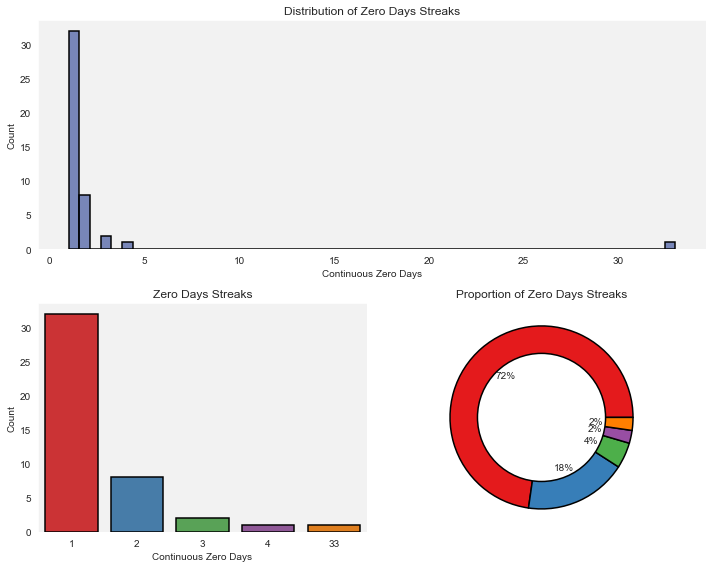

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 2)
f = plt.figure(figsize=(10, 8))

# histogram for distribution
sns.set_palette("dark")
zd_hist = f.add_subplot(gs[:-1, :])
sns.histplot(
    data=zd_streaks,
    x="date_diff",
    alpha=0.5,
    legend=False,
    edgecolor="black",
    linewidth=1.5,
).set(xlabel="Continuous Zero Days", title="Distribution of Zero Days Streaks")

# countplot for distribution
sns.set_palette("Set1")
zd_countp = f.add_subplot(gs[1, 0])
sns.countplot(data=zd_streaks, x="date_diff", edgecolor="black", linewidth=1.5).set(
    xlabel="Continuous Zero Days", ylabel="Count", title="Zero Days Streaks"
)

# donut chart for proportion
zd_prop = f.add_subplot(gs[1, 1])
## transforming table for donut chart generation
zd_streaks_count = (
    zd_streaks.groupby("date_diff")
    .count()
    .reset_index()
    .rename(columns={"date_streak_broken": "date_diff_count"})
)
zd_donut = plt.pie(
    zd_streaks_count["date_diff_count"],
    wedgeprops={"linewidth": 1.5, "edgecolor": "black"},
    autopct="%d%%",
)
plt.title("Proportion of Zero Days Streaks")

my_circle = plt.Circle((0, 0), 0.7, facecolor="white", edgecolor="black", linewidth=1.5)
p = plt.gcf()
p.gca().add_artist(my_circle)


gs.tight_layout(f)
plt.show()
plt.clf()


#### "Zero" days occur slightly more on Saturdays...
"Zero" days are approximately the same over the week. 18% of "zero" days occurred on Saturdays (16 times).

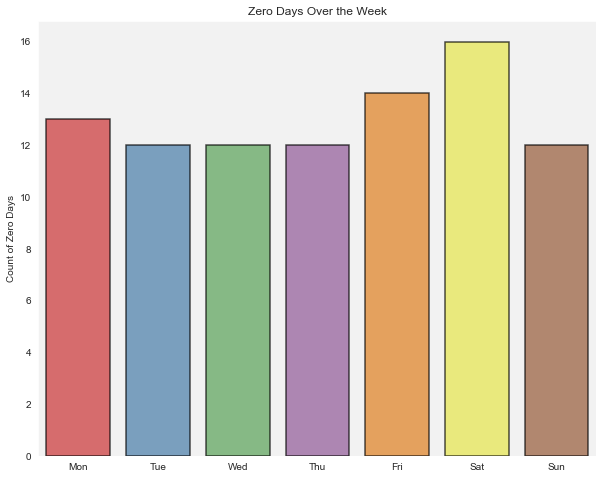

,day_of_wk,zero_days_count,proportion
0,Mon,13,0.14
1,Tue,12,0.13
2,Wed,12,0.13
3,Thu,12,0.13
4,Fri,14,0.15
5,Sat,16,0.18
6,Sun,12,0.13


<Figure size 432x288 with 0 Axes>

In [12]:
zd_days_of_wk = pd.read_sql_query(
    """
    SELECT
        SUBSTR(
            'SunMonTueWedThuFriSat',
            1 + 3 * STRFTIME('%w', date), 3
        ) AS 'day_of_wk',
        COUNT(*) AS 'zero_days_count',
        ROUND(
            1.0 * COUNT(*) / (
                SELECT COUNT(*)
                FROM zero_days
            ), 2) AS proportion
    FROM zero_days
    GROUP BY 1
    ORDER BY STRFTIME('%w', date)
""",
    engine,
)

zd_days_of_wk["day_of_wk"] = pd.Categorical(
    days_of_wk.day_of_wk,
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    ordered=True,
)
zd_days_of_wk.sort_values("day_of_wk", inplace=True)

# Plotting
sns.set_palette("Set1", 7)
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=zd_days_of_wk,
    x="day_of_wk",
    y="zero_days_count",
    edgecolor="black",
    linewidth=1.5,
    ax=ax,
    alpha=0.7,
).set(xlabel=None, ylabel="Count of Zero Days", title="Zero Days Over the Week")

plt.show()
plt.clf()

display(zd_days_of_wk)


### Geography

In [13]:
### potential insights:
# correlation between population (latest data) and COVID cases (per capita) in LGA/postcode (Greater Sydney vs Rural vs Remote)
# correlation between taxable income (latest data) and COVID cases in each LGA/postcode
# last LGAs standing (last to have reported COVID case)
# covid cases and covid-related infringement notices


### PCR vs RAT